In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fld = "../../../../../data/"
file_name = r"df.parquet.gzip"
df = pd.read_parquet(os.path.join(fld, file_name))
df.head()

,data_array,rec_coord,shot_id,sample_rate,spare1,data_array_shape
0,"[0.0009000493, 0.021326812, -0.001981188, 0.00...","[698463, 5245981]","[20221154, 20221157, 20221160, 20221163, 20221...",2000,"[652, -1, 640, -1, 624, 608, 598, 594, 590, 58...","[751, 261]"
1,"[0.0003662742, -0.0179592, 0.0009822113, -0.00...","[698477, 5245968]","[20221154, 20221157, 20221160, 20221163, 20221...",2000,"[650, -1, 640, -1, 620, 604, 595, 590, 586, 57...","[751, 261]"
2,"[0.0029259485, 0.022103101, -0.0013768432, 0.0...","[698491, 5245953]","[20221154, 20221157, 20221160, 20221163, 20221...",2000,"[650, -1, 638, -1, 618, 604, 592, 590, 584, 57...","[751, 261]"
3,"[-0.0004475608, 0.020691201, -0.00019529, 0.00...","[698505, 5245939]","[20221154, 20221157, 20221160, 20221163, 20221...",2000,"[648, -1, 632, -1, 612, 600, 589, 584, 580, 57...","[751, 261]"
4,"[-0.003561061, 0.004605557, 0.00040565367, 0.0...","[698520, 5245925]","[20221154, 20221157, 20221160, 20221163, 20221...",2000,"[656, -1, 632, -1, 612, 598, 586, 584, 578, 57...","[751, 261]"


In [3]:
# reshaping
df["data_array"] = df.apply(lambda row: row["data_array"].reshape(row["data_array_shape"]), axis=1)

In [4]:
i = 1
x = df["data_array"][i] ** 2.0

window_size_ms = 20.0
window_size = int(window_size_ms / df["sample_rate"][i] * 1e3)
window = np.ones(window_size)
print(f"Window size: {window_size_ms}ms; Number of points: {window_size}")

Window size: 20.0ms; Number of points: 10


In [5]:
accumulated_energy = np.vstack([np.convolve(xi, window, mode="same") for xi in x.T]).T
energy_ratio = accumulated_energy[window_size:] / (accumulated_energy[:-window_size] + 1e-6)

time = 1e-3 * np.arange(df["data_array"][i].shape[0]) * df["sample_rate"][i]
spare1_recognized = time[np.argmax(energy_ratio, axis=0) + window_size]

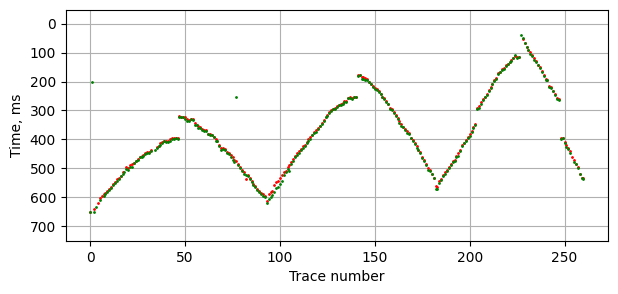

In [6]:
x = np.arange(df["data_array"][i].shape[1], dtype=int)
y = 1e-3 * np.arange(df["data_array"][i].shape[0]) * df["sample_rate"][i]
X, Y = np.meshgrid(x, y)
spare1 = df["spare1"][i]
eps = 1e-6

plt.figure(figsize=(7, 3))
plt.plot(x[spare1 > eps], spare1[spare1 > eps], ".r", ms=2)
plt.plot(x, spare1_recognized, ".g", ms=2)
plt.ylabel("Time, ms")
plt.ylim(np.min(spare1[spare1 > eps]) - 100.0, np.max(spare1[spare1 > eps]) + 100.0)
plt.gca().invert_yaxis()
plt.xlabel("Trace number")
plt.grid()
plt.show()

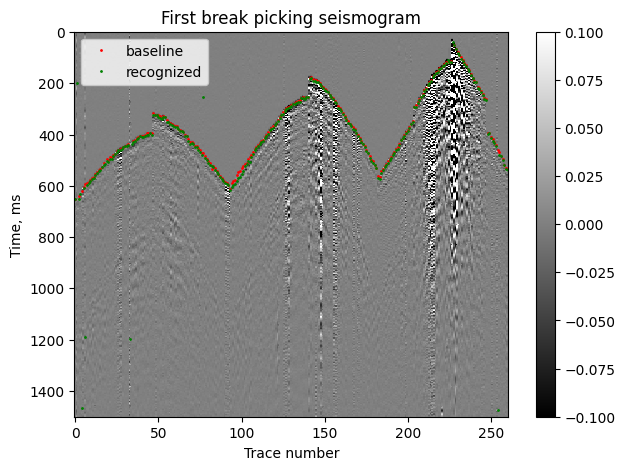

In [7]:
plt.figure(figsize=(7, 5))
plt.pcolor(X, Y, df["data_array"][i], cmap="gray", clim=(-0.1, 0.1))
plt.plot(x[spare1 > eps], spare1[spare1 > eps], ".r", ms=2, label="baseline")
plt.plot(x, spare1_recognized, ".g", ms=2, label="recognized")
plt.gca().invert_yaxis()
plt.ylabel("Time, ms")
plt.xlabel("Trace number")
plt.title("First break picking seismogram")
plt.colorbar()
plt.legend()
plt.show()